In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import schwinger,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve

In [2]:
N=3
g=1
a=8
theta=np.pi
m=0
H,sx,sy,sz=schwinger(N=N,g=g,a=a,theta=theta,m=m)

In [3]:
Q=sx[-1]+ 1.1*sy[-1]+0.9*sz[-1] ## take a look at the berlin guys paper to see if this is a bad coupling operator

In [4]:
E01=1#H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
w0=0.5*a
gamma=w0/2
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
lam

True


1.9679896712654306

In [5]:
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)
rho0=psi0*psi0.dag()
times=np.linspace(0,50,500)
tfit=np.linspace(0, 50, 5000)

In [6]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-9.04e-02 |-3.51e+00 |2.31e-21                              | 1         |-5.00e-01 |-1.00e+00 |3.87e+00                              
 2         | 5.15e-01 |-1.02e+00 |3.86e+00                              |                                                                        
                                                                        |A  normalized RM

In [7]:
times2 = np.linspace(0,50,100)
cvis = bath.correlation_function(times2)

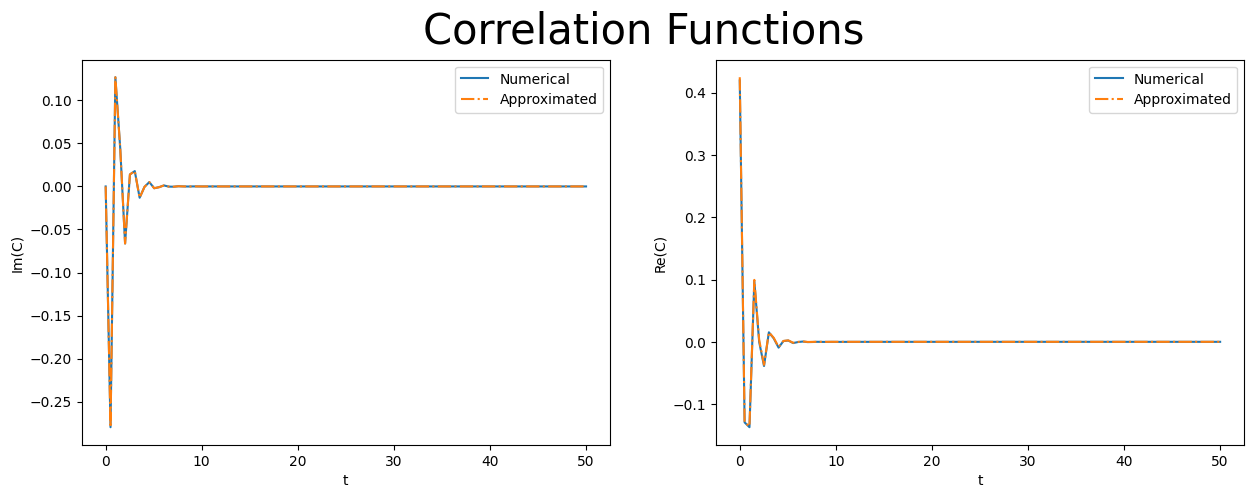

In [8]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [9]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   3.32s. Est. time left: 00:00:00:29
20.0%. Run time:   6.14s. Est. time left: 00:00:00:24
30.1%. Run time:   7.83s. Est. time left: 00:00:00:18
40.1%. Run time:   9.51s. Est. time left: 00:00:00:14
50.1%. Run time:  11.30s. Est. time left: 00:00:00:11
60.1%. Run time:  13.21s. Est. time left: 00:00:00:08
70.1%. Run time:  15.07s. Est. time left: 00:00:00:06
80.2%. Run time:  17.16s. Est. time left: 00:00:00:04
90.2%. Run time:  19.31s. Est. time left: 00:00:00:02
100.0%. Run time:  21.31s. Est. time left: 00:00:00:00
Total run time:  21.31s


In [10]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

Calculating Integrals ...: 100%|█████████████| 25/25 [00:05<00:00,  4.83it/s]
Calculating time dependent generators ...: 100%|█| 500/500 [00:00<00:00, 1298
Computing Exponential of Generators . . . .: 100%|█| 500/500 [00:03<00:00, 16


In [11]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.03e-02 |-1.12e+00 |7.38e-15                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.71e-02 |-5.34e+00 |6.41e-11                              |                                                                        
                                                                        |A  normalized RM

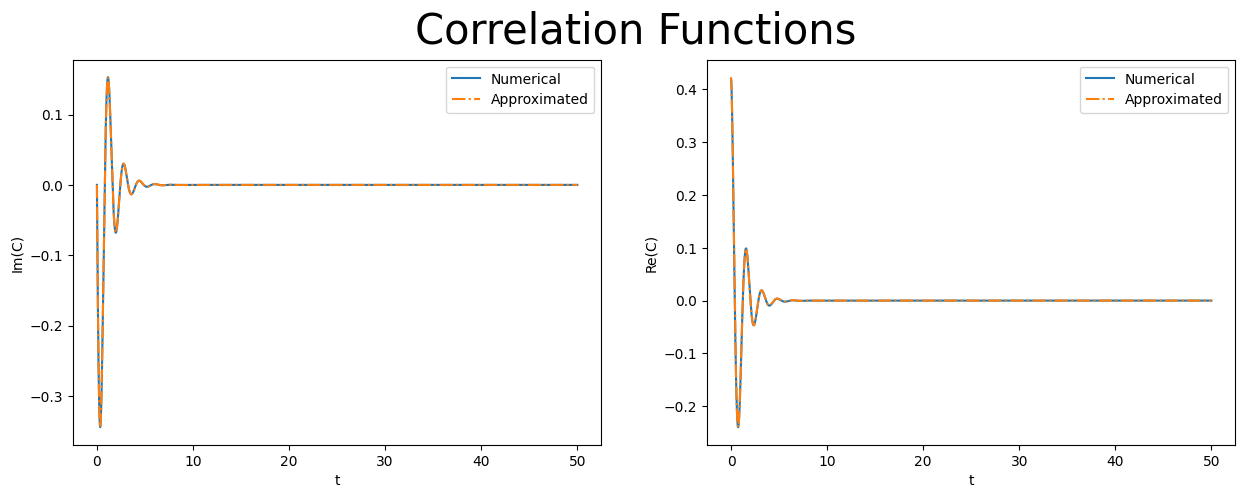

In [30]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [31]:
ans = example.evolution(rho0, Ncutoff, times, options={
                        "atol": 1e-14, "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

In [32]:
results=[result,result_cum,resultBR,resultBR2,ans]

In [3]:
result.states[0]

NameError: name 'result' is not defined

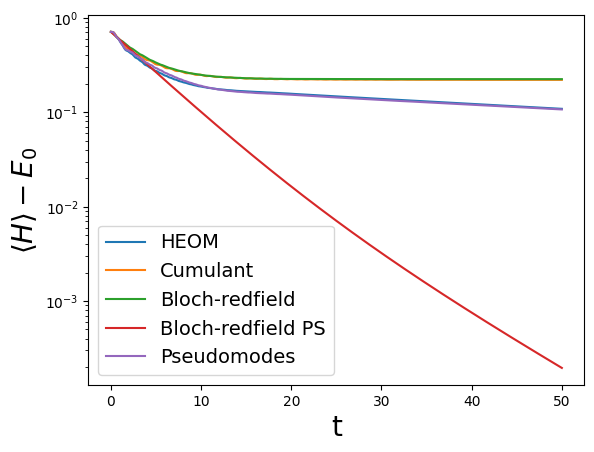

In [33]:
plot_ground(results,H/a,times)

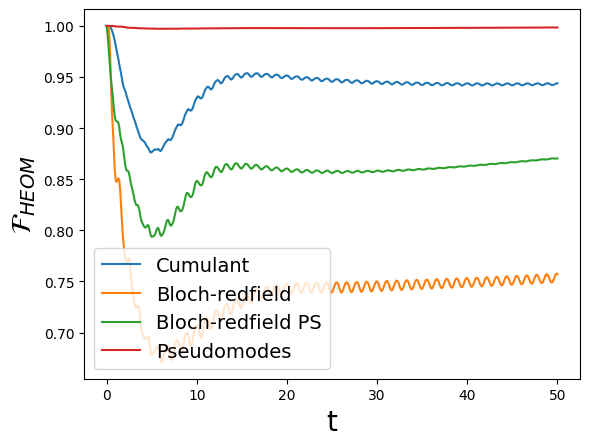

In [34]:
plot_fidelities(results,H,times)

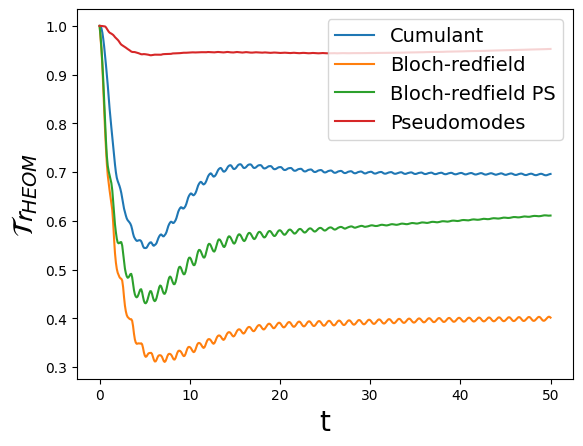

In [35]:
plot_trd(results,H,times)

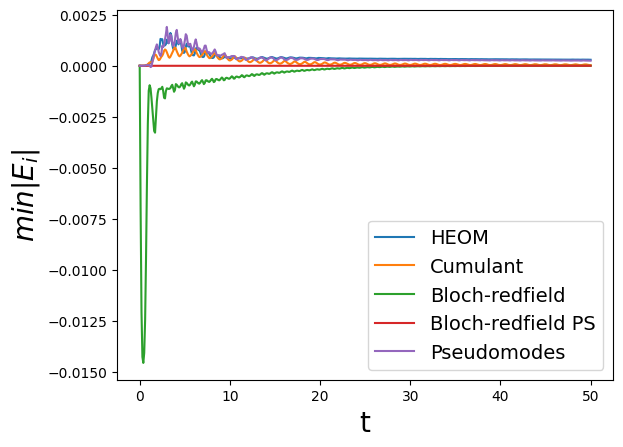

In [36]:
plot_positivity(results,H,times)

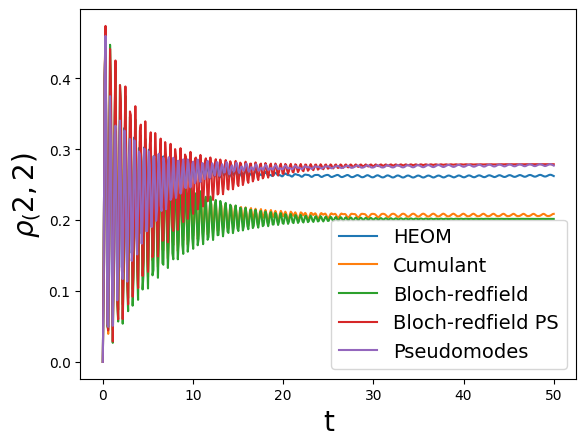

In [37]:
plot_populations(results,H,times,l=2,m=2)

In [38]:
from qutip import qsave

In [21]:
qsave(results,f"N={N}_schwinger_{lam}_nocheating_seems_hard")